Import all we need and prepare data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import deepdish as dd
from scipy.signal import savgol_filter
from matplotlib.lines import Line2D
%matplotlib inline
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
import cmocean

In [2]:
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 20    

In [3]:
import statsmodels.formula.api as smf

from statsmodels.stats.anova import anova_lm

import statsmodels.api as smapi

import seaborn as sns

import statsmodels as sm

In [4]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import cross_val_score

class SMFormulaWrapper(BaseEstimator, RegressorMixin):
    """ A sklearn-style wrapper for formula-based statsmodels regressors """
    def __init__(self, model_class, formula):
        self.model_class = model_class
        self.formula = formula
    def fit(self, X, y=None):
        self.model_ = self.model_class(self.formula, data=X)
        self.results_ = self.model_.fit()
    def predict(self, X):
        return self.results_.predict(X)

In [5]:
esum = dd.io.load("experiments_summary.h5")

lobe_data = pd.DataFrame(esum["lobe_summary"])

lobe_activities = np.row_stack(esum["df_fs"])

lobe_data["df_f"] = np.mean(lobe_activities[:, 31:35], 1)

In [6]:
lobe_data=pd.DataFrame(lobe_data)

In [7]:
len(lobe_activities[0])

80

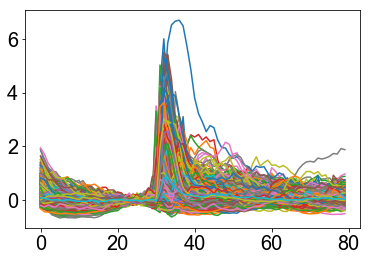

In [8]:
plt.plot(lobe_activities.T)
plt.show()

In [9]:
valence_map = {
"Vinegar": 1,
"high_Vinegar":np.nan,
"Yeast": 1,
"Isoamylacetate": np.nan,
"2-Heptanone": np.nan,
"1-Heptanone": np.nan,
    
"cVA": np.nan,
"3Octanol": np.nan,
"Ethanol": np.nan,

"1-Hexanol": np.nan,
"Peppermint": -1,
"4MCH": np.nan,
"Citronella": -1,
"Geosmin": -1,
}

lobe_data["valence"] = [valence_map[s] for s in lobe_data.stimulus]

In [10]:
lobes = lobe_data.lobe.unique()
n_lobes = len(lobes)
n_time = lobe_activities.shape[1]

In [11]:
Lobes=lobe_data.lobe.unique()

In [12]:
Stimuli=lobe_data.stimulus.unique()

In [13]:
Flies=lobe_data.fly_id.unique()

In [14]:
FedFlies=lobe_data[lobe_data["hours_starved"]==0].fly_id.unique()

In [15]:
len(Flies)

201

In [16]:
len(FedFlies)

90

In [17]:
165-62

103

In [18]:
# Contrasts
lobe_data['dorsal_to_ventral_val']=[int(s) for s in lobe_data.dorsal_to_ventral]
lobe_data['virgin_val']=[int(s) for s in lobe_data.virgin]
# Normalization
lobe_data['starved']=[int(s)/24 for s in lobe_data.hours_starved]

In [19]:
LobesGreek=['α1', 'α2', 'α3', "α'1", "α'2", "α'3", 'β1', 'β2', "β'1", "β'2",
       'γ1', 'γ2', 'γ3', 'γ4', 'γ5']
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 16

In [20]:
lobe_data=lobe_data.replace("1-Heptanone",'2-Heptanone')

In [21]:
lobe_data=lobe_data[lobe_data["stimulus"]!="high_Vinegar"]

In [22]:
#lobe_data=lobe_data[lobe_data["stimulus"]!="cVA"]

In [23]:
Flies=lobe_data.fly_id.unique()

In [24]:
len(Flies)

185

In [25]:
lobe_data.stimulus.unique()

array(['Citronella', 'Vinegar', 'Yeast', 'Peppermint', '2-Heptanone',
       '1-Hexanol', 'cVA', 'Geosmin', '4MCH', 'Isoamylacetate',
       '3Octanol', 'Ethanol'], dtype=object)

# Finding good regression models

## Deciding if using individual flies is meaningful

As there are just a couple of odors per fly, adding fly ID is likely to overfit.

In [26]:
result = smf.ols(formula="df_f ~ lobe+stimulus+order_presented+dorsal_to_ventral_val+fly_id+starved", data=lobe_data).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   df_f   R-squared:                       0.381
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     15.29
Date:                Mon, 09 Mar 2020   Prob (F-statistic):               0.00
Time:                        16:34:42   Log-Likelihood:                -2690.9
No. Observations:                5430   AIC:                             5804.
Df Residuals:                    5219   BIC:                             7196.
Df Model:                         210                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          0.2445      0.128      1.910      0.056      -0.006       0.496
lobe[T.a2]                         0.2088      0.030      6.933      0.000       0.150       0.268
lobe[T.a3]                         0.2453      0.030      8.145      0.000       0.186       0.304
lobe[T.ap1]                        0.3101      0.030     10.299      0.000       0.251       0.369
lobe[T.ap2]                        0.2012      0.030      6.681      0.000       0.142       0.260
lobe[T.ap3]                        0.6560      0.030     21.784      0.000       0.597       0.715
lobe[T.b1]                         0.3267      0.030     10.850      0.000       0.268       0.386
lobe[T.b2]                         0.5223      0.030     17.344      0.000       0.463       0.581
lobe[T.bp1]                        0.9422      0.030     31.288      0.000       0.883       1.001
lobe[T.bp2]                        0.5145      0.030     17.085      0.000       0.455       0.574
lobe[T.g1]                         0.2565      0.030      8.519      0.000       0.197       0.316
lobe[T.g2]                         0.3322      0.030     11.032      0.000       0.273       0.391
lobe[T.g3]                         0.6166      0.030     20.477      0.000       0.558       0.676
lobe[T.g4]                         0.4541      0.030     15.081      0.000       0.395       0.513
lobe[T.g5]                         0.0278      0.030      0.923      0.356      -0.031       0.087
stimulus[T.2-Heptanone]           -0.1039      0.080     -1.292      0.196      -0.262       0.054
stimulus[T.3Octanol]               0.0334      0.093      0.358      0.720      -0.149       0.216
stimulus[T.4MCH]                   0.1653      0.090      1.832      0.067      -0.012       0.342
stimulus[T.Citronella]            -0.1306      0.107     -1.224      0.221      -0.340       0.079
stimulus[T.Ethanol]               -0.0982      0.100     -0.985      0.325      -0.294       0.097
stimulus[T.Geosmin]               -0.2496      0.102     -2.440      0.015      -0.450      -0.049
stimulus[T.Isoamylacetate]         0.0067      0.073      0.092      0.927      -0.137       0.151
stimulus[T.Peppermint]            -0.0047      0.068     -0.068      0.946      -0.138       0.129
stimulus[T.Vinegar]               -0.0243      0.103     -0.236      0.813      -0.226       0.177
stimulus[T.Yeast]                  0.0479      0.103      0.467      0.641      -0.153       0.249
stimulus[T.cVA]                   -0.1067      0.123     -0.865      0.387      -0.349       0.135
fly_id[T.2016-08-10 00:00:000]    -0.2608      0.106     -2.451      0.014      -0.469      -0.052
fly_id[T.2016-08-11 00:00:000]    -0.2281      0.106     -2.145      0.032      -0.437      -0.020
fly_id[T.2016-

Indeed, show up as warning in the summary

### Characterize multicolinearity

from wikipedia:
"the quotient of the variance in a model with multiple terms by the variance of a model with one term alone"

"how much the variance (the square of the estimate's standard deviation) of an estimated regression coefficient is increased because of collinearity"

from https://www.statpac.com/manual/index.htm?turl=varianceinflationfactors.htm
"the degree to which a regression coefficient will be affected because of the variable's redundancy with other independent variables."

In [27]:
y, X = dmatrices('df_f ~ lobe+stimulus+order_presented+dorsal_to_ventral_val+fly_id+starved', lobe_data, return_type='dataframe')
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif.round(1)

C:\Users\aimon\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:181: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF Factor,features
0,542.500000,Intercept
1,1.900000,lobe[T.a2]
2,1.900000,lobe[T.a3]
3,1.900000,lobe[T.ap1]
4,1.900000,lobe[T.ap2]
5,1.900000,lobe[T.ap3]
6,1.900000,lobe[T.b1]
7,1.900000,lobe[T.b2]
8,1.900000,lobe[T.bp1]
9,1.900000,lobe[T.bp2]


Many fly_id factors have an infinite VIF, and many factors have high VIF.

In [28]:
y, X = dmatrices('df_f ~ lobe+stimulus+order_presented+dorsal_to_ventral_val+starved-1', lobe_data, return_type='dataframe')
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif.round(1)

,VIF Factor,features
0,2.3,lobe[a1]
1,2.3,lobe[a2]
2,2.3,lobe[a3]
3,2.3,lobe[ap1]
4,2.3,lobe[ap2]
5,2.3,lobe[ap3]
6,2.3,lobe[b1]
7,2.3,lobe[b2]
8,2.3,lobe[bp1]
9,2.3,lobe[bp2]


Now VIFs are reasonable

In [29]:
result = smf.ols(formula="df_f ~ lobe+stimulus+order_presented+dorsal_to_ventral_val+starved", data=lobe_data).fit()

aov_table = anova_lm(result, typ=2)
print(result.rsquared)
aov_table

0.25738553079932003


,sum_sq,df,F,PR(>F)
lobe,313.009229,14.0,117.518296,1.208695e-298
stimulus,34.680558,11.0,16.571803,1.343960e-32
order_presented,1.083264,1.0,5.693912,1.705811e-02
dorsal_to_ventral_val,3.408663,1.0,17.916798,2.346029e-05
starved,2.529495,1.0,13.295667,2.685245e-04
Residual,1027.537780,5401.0,NaN,NaN


We thus choose to remove fly_id from the model. We will nevertheless do one mixed model (see below) to see if fly_id affects regression coefficients.

### Interaction with lobes

We want to know if different lobes respond differently to different factors

In [30]:
resInter = smf.ols(formula="df_f ~ lobe*(stimulus+order_presented+dorsal_to_ventral_val+starved)", data=lobe_data).fit()

resInter.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   df_f   R-squared:                       0.356
Model:                            OLS   Adj. R-squared:                  0.328
Method:                 Least Squares   F-statistic:                     12.84
Date:                Mon, 09 Mar 2020   Prob (F-statistic):               0.00
Time:                        16:35:23   Log-Likelihood:                -2798.3
No. Observations:                5430   AIC:                             6047.
Df Residuals:                    5205   BIC:                             7532.
Df Model:                         224                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                  0.2160      0.100      2.169      0.030       0.021       0.411
lobe[T.a2]                                 0.1460      0.141      1.037      0.300      -0.130       0.422
lobe[T.a3]                                 0.1784      0.141      1.267      0.205      -0.098       0.455
lobe[T.ap1]                                0.3392      0.141      2.408      0.016       0.063       0.615
lobe[T.ap2]                                0.1167      0.141      0.829      0.407      -0.159       0.393
lobe[T.ap3]                                0.5920      0.141      4.203      0.000       0.316       0.868
lobe[T.b1]                                 0.2849      0.141      2.023      0.043       0.009       0.561
lobe[T.b2]                                 0.4893      0.141      3.474      0.001       0.213       0.765
lobe[T.bp1]                                0.9091      0.141      6.454      0.000       0.633       1.185
lobe[T.bp2]                                0.5101      0.141      3.621      0.000       0.234       0.786
lobe[T.g1]                                 0.3046      0.141      2.163      0.031       0.028       0.581
lobe[T.g2]                                 0.4941      0.141      3.508      0.000       0.218       0.770
lobe[T.g3]                                 0.7779      0.141      5.523      0.000       0.502       1.054
lobe[T.g4]                                 0.6610      0.141      4.693      0.000       0.385       0.937
lobe[T.g5]                                 0.0562      0.141      0.399      0.690      -0.220       0.332
stimulus[T.2-Heptanone]                   -0.1427      0.129     -1.103      0.270      -0.396       0.111
stimulus[T.3Octanol]                       0.0725      0.137      0.531      0.595      -0.195       0.340
stimulus[T.4MCH]                           0.0514      0.128      0.402      0.688      -0.200       0.302
stimulus[T.Citronella]                    -0.1406      0.110     -1.279      0.201      -0.356       0.075
stimulus[T.Ethanol]                       -0.0686      0.147     -0.465      0.642      -0.358       0.220
stimulus[T.Geosmin]                       -0.1859      0.142     -1.313      0.189      -0.463       0.092
stimulus[T.Isoamylacetate]                -0.0373      0.124     -0.301      0.764      -0.281       0.206
stimulus[T.Peppermint]                    -0.0995      0.124     -0.801      0.423      -0.343       0.144
stimulus[T.Vinegar]                       -0.1933      0.112     -1.720      0.086      -0.414       0.027
stimulus[T.Yeast]                         -0.1602      0.112     -1.435      0.151      -0.379       0.059
stimulus[T.cVA]                           -0.0866      0.110     -0.790      0.429     

In [31]:
aov_table = anova_lm(resInter, typ=2)
print(resInter.rsquared)
aov_table

0.3559549739696527


,sum_sq,df,F,PR(>F)
lobe,313.009229,14.0,130.586782,0.000000e+00
stimulus,34.680558,11.0,18.414651,1.263860e-36
lobe:stimulus,116.885093,154.0,4.433110,2.977103e-62
order_presented,1.083264,1.0,6.327096,1.192056e-02
lobe:order_presented,1.456470,14.0,0.607636,8.611169e-01
dorsal_to_ventral_val,3.408663,1.0,19.909215,8.292013e-06
lobe:dorsal_to_ventral_val,7.141583,14.0,2.979453,1.433614e-04
starved,2.529495,1.0,14.774196,1.226271e-04
lobe:starved,6.416982,14.0,2.677151,6.440503e-04
Residual,891.149612,5205.0,NaN,NaN


In [33]:
aov_table.to_csv("FullAnovaTable_no3oct&Mch.csv")

Order presented is not significant so remove it. Also make sure there is no intercept for global lobe response, and remove the global effect of starvation to see the simple effects of starvation for each lobe.

In [34]:
resnoid = smf.ols(formula="df_f ~ lobe*(stimulus+order_presented+dorsal_to_ventral_val)+lobe:starved-1", data=lobe_data).fit()
resnoid.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   df_f   R-squared:                       0.356
Model:                            OLS   Adj. R-squared:                  0.328
Method:                 Least Squares   F-statistic:                     12.84
Date:                Mon, 09 Mar 2020   Prob (F-statistic):               0.00
Time:                        16:43:17   Log-Likelihood:                -2798.3
No. Observations:                5430   AIC:                             6047.
Df Residuals:                    5205   BIC:                             7532.
Df Model:                         224                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
lobe[a1]                                   0.2160      0.100      2.169      0.030       0.021       0.411
lobe[a2]                                   0.3620      0.100      3.635      0.000       0.167       0.557
lobe[a3]                                   0.3944      0.100      3.960      0.000       0.199       0.590
lobe[ap1]                                  0.5552      0.100      5.575      0.000       0.360       0.750
lobe[ap2]                                  0.3328      0.100      3.341      0.001       0.138       0.528
lobe[ap3]                                  0.8080      0.100      8.113      0.000       0.613       1.003
lobe[b1]                                   0.5010      0.100      5.030      0.000       0.306       0.696
lobe[b2]                                   0.7054      0.100      7.082      0.000       0.510       0.901
lobe[bp1]                                  1.1251      0.100     11.296      0.000       0.930       1.320
lobe[bp2]                                  0.7261      0.100      7.290      0.000       0.531       0.921
lobe[g1]                                   0.5206      0.100      5.227      0.000       0.325       0.716
lobe[g2]                                   0.7101      0.100      7.130      0.000       0.515       0.905
lobe[g3]                                   0.9939      0.100      9.979      0.000       0.799       1.189
lobe[g4]                                   0.8771      0.100      8.806      0.000       0.682       1.072
lobe[g5]                                   0.2722      0.100      2.733      0.006       0.077       0.467
stimulus[T.2-Heptanone]                   -0.1427      0.129     -1.103      0.270      -0.396       0.111
stimulus[T.3Octanol]                       0.0725      0.137      0.531      0.595      -0.195       0.340
stimulus[T.4MCH]                           0.0514      0.128      0.402      0.688      -0.200       0.302
stimulus[T.Citronella]                    -0.1406      0.110     -1.279      0.201      -0.356       0.075
stimulus[T.Ethanol]                       -0.0686      0.147     -0.465      0.642      -0.358       0.220
stimulus[T.Geosmin]                       -0.1859      0.142     -1.313      0.189      -0.463       0.092
stimulus[T.Isoamylacetate]                -0.0373      0.124     -0.301      0.764      -0.281       0.206
stimulus[T.Peppermint]                    -0.0995      0.124     -0.801      0.423      -0.343       0.144
stimulus[T.Vinegar]                       -0.1933      0.112     -1.720      0.086      -0.414       0.027
stimulus[T.Yeast]                         -0.1602      0.112     -1.435      0.151      -0.379       0.059
stimulus[T.cVA]                           -0.0866      0.110     -0.790      0.429     

In [35]:
resnoidb = smf.ols(formula="df_f ~ lobe*(stimulus+order_presented+dorsal_to_ventral_val)+lobe:starved+stimulus:starved-1", data=lobe_data).fit()
resnoidb.summary()

C:\Users\aimon\Anaconda3\lib\site-packages\statsmodels\base\model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\aimon\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\aimon\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\aimon\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   df_f   R-squared:                       0.366
Model:                            OLS   Adj. R-squared:                  0.337
Method:                 Least Squares   F-statistic:                     12.80
Date:                Mon, 09 Mar 2020   Prob (F-statistic):               0.00
Time:                        16:43:18   Log-Likelihood:                -2756.8
No. Observations:                5430   AIC:                             5984.
Df Residuals:                    5195   BIC:                             7535.
Df Model:                         234                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
lobe[a1]                                   0.3061      0.102      2.987      0.003       0.105       0.507
lobe[a2]                                   0.4521      0.102      4.412      0.000       0.251       0.653
lobe[a3]                                   0.4845      0.102      4.729      0.000       0.284       0.685
lobe[ap1]                                  0.6453      0.102      6.298      0.000       0.444       0.846
lobe[ap2]                                  0.4228      0.102      4.127      0.000       0.222       0.624
lobe[ap3]                                  0.8981      0.102      8.765      0.000       0.697       1.099
lobe[b1]                                   0.5910      0.102      5.768      0.000       0.390       0.792
lobe[b2]                                   0.7954      0.102      7.763      0.000       0.595       0.996
lobe[bp1]                                  1.2151      0.102     11.860      0.000       1.014       1.416
lobe[bp2]                                  0.8161      0.102      7.966      0.000       0.615       1.017
lobe[g1]                                   0.6107      0.102      5.960      0.000       0.410       0.812
lobe[g2]                                   0.8002      0.102      7.810      0.000       0.599       1.001
lobe[g3]                                   1.0839      0.102     10.580      0.000       0.883       1.285
lobe[g4]                                   0.9671      0.102      9.439      0.000       0.766       1.168
lobe[g5]                                   0.3623      0.102      3.536      0.000       0.161       0.563
stimulus[T.2-Heptanone]                   -0.2070      0.134     -1.543      0.123      -0.470       0.056
stimulus[T.3Octanol]                      -0.0345      0.141     -0.245      0.807      -0.311       0.242
stimulus[T.4MCH]                          -0.1765      0.132     -1.339      0.181      -0.435       0.082
stimulus[T.Citronella]                    -0.2926      0.115     -2.546      0.011      -0.518      -0.067
stimulus[T.Ethanol]                       -0.1406      0.152     -0.923      0.356      -0.439       0.158
stimulus[T.Geosmin]                       -0.3066      0.145     -2.113      0.035      -0.591      -0.022
stimulus[T.Isoamylacetate]                -0.0482      0.128     -0.376      0.707      -0.300       0.203
stimulus[T.Peppermint]                    -0.1553      0.128     -1.212      0.226      -0.407       0.096
stimulus[T.Vinegar]                       -0.2814      0.117     -2.399      0.016      -0.511      -0.051
stimulus[T.Yeast]                         -0.2533      0.116     -2.181      0.029      -0.481      -0.026
stimulus[T.cVA]                           -0.1789      0.112     -1.597      0.110     

Evaluate the model using cross validation and VIF

In [36]:
#formulanoid="df_f ~ lobe*(stimulus+order_presented+dorsal_to_ventral_val)+starved:lobe-1"
##cv_ols_noid = cross_val_score(SMFormulaWrapper(smf.ols, formulanoid),lobe_data, lobe_data['df_f'], cv=6)
#print ("All no ID "+str(np.mean(cv_ols_noid)))

In [37]:
y, X = dmatrices('df_f ~ lobe*(stimulus+order_presented+dorsal_to_ventral_val)+starved:lobe-1', lobe_data, return_type='dataframe')
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

In [38]:
np.max(vif.round(1))

VIF Factor               58.1
features      stimulus[T.cVA]
dtype: object

There is definitely some overfitting and still multicolinearity: will need to compare the coefficient obtained with this model with simpler and/or regularized models

#### Regularized model:lasso

In [39]:
result_reg_lasso = smf.ols(formula="df_f ~ lobe*(stimulus+order_presented+dorsal_to_ventral_val)+starved:lobe-1", data=lobe_data).fit_regularized(L1_wt=1)

In [40]:
result_reg = smf.ols(formula="df_f ~ lobe*(stimulus+order_presented+dorsal_to_ventral_val)+starved:lobe-1", data=lobe_data).fit_regularized()

In [41]:
result_reg_ridge = smf.ols(formula="df_f ~ lobe*(stimulus+order_presented+dorsal_to_ventral_val)+starved:lobe-1", data=lobe_data).fit_regularized(L1_wt=0)

#### Mixed model with fly individuality

In [42]:
resAllmm = smf.mixedlm(formula="df_f ~ lobe*(stimulus+order_presented+dorsal_to_ventral_val)+starved:lobe-1", data=lobe_data,groups=lobe_data["fly_id"]).fit()

resAllmm.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                      Mixed Linear Model Regression Results
=================================================================================
Model:                     MixedLM         Dependent Variable:         df_f      
No. Observations:          5430            Method:                     REML      
No. Groups:                185             Scale:                      0.1433    
Min. group size:           15              Likelihood:                 -2863.2076
Max. group size:           60              Converged:                  Yes       
Mean group size:           29.4                                                  
---------------------------------------------------------------------------------
                                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------
lobe[a1]                                0.194    0.101  1.918 0.055 -0.004  0.392
lobe[a2]                                0.340    0.101  3.363 0.001  0.142  0.538
lobe[a3]                                0.372    0.101  3.683 0.000  0.174  0.570
lobe[ap1]                               0.533    0.101  5.275 0.000  0.335  0.731
lobe[ap2]                               0.310    0.101  3.073 0.002  0.112  0.509
lobe[ap3]                               0.786    0.101  7.777 0.000  0.588  0.984
lobe[b1]                                0.479    0.101  4.738 0.000  0.281  0.677
lobe[b2]                                0.683    0.101  6.761 0.000  0.485  0.881
lobe[bp1]                               1.103    0.101 10.915 0.000  0.905  1.301
lobe[bp2]                               0.704    0.101  6.966 0.000  0.506  0.902
lobe[g1]                                0.498    0.101  4.933 0.000  0.300  0.696
lobe[g2]                                0.688    0.101  6.808 0.000  0.490  0.886
lobe[g3]                                0.972    0.101  9.617 0.000  0.774  1.170
lobe[g4]                                0.855    0.101  8.460 0.000  0.657  1.053
lobe[g5]                                0.250    0.101  2.474 0.013  0.052  0.448
stimulus[T.2-Heptanone]                -0.138    0.128 -1.078 0.281 -0.389  0.113
stimulus[T.3Octanol]                    0.068    0.135  0.505 0.613 -0.197  0.334
stimulus[T.4MCH]                        0.127    0.128  0.993 0.321 -0.124  0.378
stimulus[T.Citronella]                 -0.139    0.110 -1.259 0.208 -0.355  0.077
stimulus[T.Ethanol]                    -0.046    0.146 -0.313 0.754 -0.333  0.241
stimulus[T.Geosmin]                    -0.157    0.142 -1.105 0.269 -0.436  0.122
stimulus[T.Isoamylacetate]             -0.026    0.122 -0.212 0.832 -0.264  0.213
stimulus[T.Peppermint]                 -0.144    0.121 -1.187 0.235 -0.382  0.094
stimulus[T.Vinegar]                    -0.145    0.112 -1.291 0.197 -0.365  0.075
stimulus[T.Yeast]                      -0.100    0.112 -0.897 0.370 -0.319  0.119
stimulus[T.cVA]                        -0.066    0.113 -0.582 0.561 -0.288  0.156
lobe[T.a2]:stimulus[T.2-Heptanone]      0.215    0.167  1.286 0.198 -0.113  0.543
lobe[T.a3]:stimulus[T.2-Heptanone]      0.239    0.167  1.431 0.153 -0.089  0.567
lobe[T.ap1]:stimulus[T.2-Heptanone]     0.181    0.167  1.081 0.280 -0.147  0.509
lobe[T.ap2]:stimulus[T.2-Heptanone]     0.261    0.167  1.558 0.119 -0.067  0.589
lobe[T.ap3]:stimulus[T.2-Heptanone]     0.005    0.167  0.031 0.976 -0.323  0.333
lobe[T.b1]:stimulus[T.2-Heptanone]     -0.160    0.167 -0.956 0.339 -0.488  0.168
lobe[T.b2]:stimulus[T.2-Heptanone]     -0.162    0.167 -0.966 0.334 -0.490  0.166
lobe[T.bp1]:stimulus[T.2-Heptanone]    -0.207    0.167 -1.236 0.217 -0.535  0.121
lobe[T.bp2]:stimulus[T.2-Heptanone]    -0.103    0.167 -0.617 0.537 -0.431  0.225
lobe[T.g1]:stimulus[T.2-Heptanone]      0.218    0.167  1.302 0.193 -0.110  0.546
lobe[T.g2]:stimulus[T.2-Heptanone]      0.004    0.167  0.021 0.983 -0.324  0.332
lobe[T.g3]:stimulus[T.2-Heptanone]   

In [43]:
sum((resAllmm.predict(lobe_data)-np.mean(resAllmm.predict(lobe_data)))**2)/sum((lobe_data['df_f']-np.mean(lobe_data['df_f']))**2)

0.3566498009432736

#### Minimal models

In [44]:
reslobe = smf.ols(formula="df_f ~ lobe-1", data=lobe_data).fit()
y, X = dmatrices('df_f ~ lobe-1', lobe_data, return_type='dataframe')
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
np.max(vif.round(1))

VIF Factor           1
features      lobe[g5]
dtype: object

In [45]:
resstarved = smf.ols(formula="df_f ~ lobe+lobe:starved-1", data=lobe_data).fit()
y, X = dmatrices('df_f ~ lobe+lobe:starved-1', lobe_data, return_type='dataframe')
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
np.max(vif.round(1))

VIF Factor                 1.9
features      lobe[g5]:starved
dtype: object

#### Compare all models

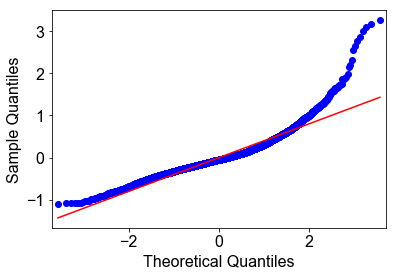

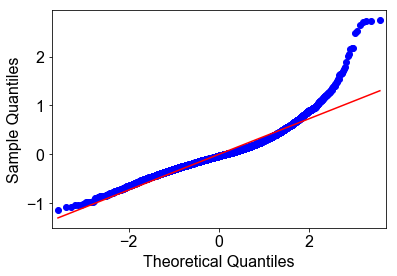

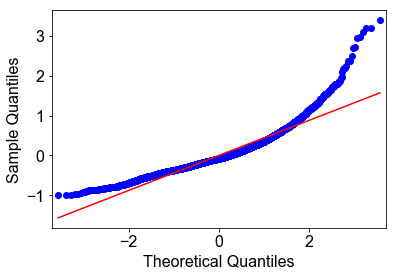

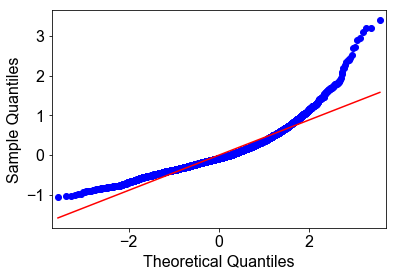

In [46]:
residuals = resnoidb.resid 
fig = smapi.qqplot(residuals, line='s')
residuals = resAllmm.resid 
fig = smapi.qqplot(residuals, line='s')
residuals = resstarved.resid 
fig = smapi.qqplot(residuals, line='s')
residuals = reslobe.resid 
fig = smapi.qqplot(residuals, line='s')
plt.show()

The mixed model has the cleanest QQ plot (although still miss an effect in fourth quantile)

In [47]:
aov_table2 = anova_lm(resnoid,resstarved,reslobe)
aov_table2

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,5205.0,891.149612,0.0,NaN,NaN,NaN
1,5400.0,1054.525520,-195.0,-163.375908,4.237381,NaN
2,5415.0,1070.666719,-15.0,-16.141199,5.442378,NaN


In [48]:
formulastim="df_f ~ lobe-1"
cv_ols_stim = cross_val_score(SMFormulaWrapper(smf.ols, formulastim),lobe_data, lobe_data['df_f'],scoring='explained_variance', cv=6)
print ("Only lobe: cross validated "+str(np.mean(cv_ols_stim))+" Rsquare:"+str(reslobe.rsquared))

formulastarved="df_f ~ lobe+lobe:starved-1"
cv_ols_starved = cross_val_score(SMFormulaWrapper(smf.ols, formulastarved),lobe_data, lobe_data['df_f'],scoring='explained_variance', cv=6)
print ("Only lobe and starved: cross validated "+str(np.mean(cv_ols_starved))+" Rsquare:"+str(resstarved.rsquared))

Only lobe: cross validated 0.21402598887966695 Rsquare:0.22621570409050484
Only lobe and starved: cross validated 0.2140411474328432 Rsquare:0.2378811513191722


In [49]:
print(reslobe.aic,reslobe.bic)
print(resstarved.aic,resstarved.bic)
print(resnoid.aic,resnoid.bic)

6623.211824183032 6722.207240376952
6570.726679545065 6768.717511932904
6046.673748798996 7531.604991707792


As the bic and the aic give contradictory results, we report all coefficients 

#### Summary graphs for the coefficients

In [50]:
import matplotlib.transforms as transforms

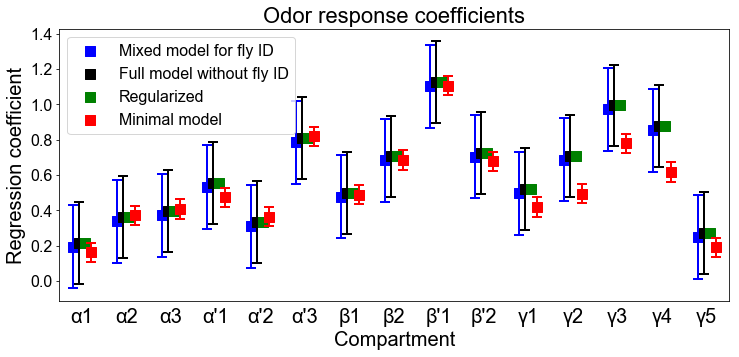

In [51]:
fig, ax = plt.subplots(figsize=(12, 5))
offset = lambda p: transforms.ScaledTranslation(p/72.,0, plt.gcf().dpi_scale_trans)
trans = plt.gca().transData

###################3

err_series = resAllmm.params - resAllmm.conf_int(alpha=0.02)[0]
coef_df = pd.DataFrame({'coef': resAllmm.params[0:15],
                       'err': err_series.values[0:15],
                       'varname': err_series.index.values[0:15]
                      })


coef_df.plot(x='varname', y='coef', kind='bar', 
            ax=ax, color='none', 
            yerr='err', 
            error_kw=dict(ecolor='blue', lw=2, capsize=5, capthick=2,transform=trans+offset(-9)),
            label='')

ax.scatter(x=pd.np.arange(coef_df.shape[0]), 
          marker='s', s=120,transform=trans+offset(-9), 
          y=coef_df['coef'], color='blue',label="Mixed model for fly ID")

##################3
err_series = resnoid.params - resnoid.conf_int(alpha=0.02)[0]
coef_df = pd.DataFrame({'coef': resnoid.params[0:15],
                        'err': err_series.values[0:15],
                        'varname': err_series.index.values[0:15]
                       })


coef_df.plot(x='varname', y='coef', kind='bar', 
             ax=ax, color='none', 
             yerr='err',
             error_kw=dict(ecolor='black', lw=2, capsize=5, capthick=2,transform=trans+offset(-3)),
             label='')

ax.scatter(x=pd.np.arange(coef_df.shape[0]), 
           marker='s', s=120, transform=trans+offset(-3),
           y=coef_df['coef'], color='black',label="Full model without fly ID")
######################

#err_series = result_reg.params - result_reg.conf_int()[0]
coef_df = pd.DataFrame({'coef': result_reg_ridge.params[0:15],
                        #'err': err_series.values[0:15],
                        #'varname': err_series.index.values[0:15]
                       })
coef_df.plot(y='coef', kind='bar', 
             ax=ax, color='None',label='')

ax.scatter(x=pd.np.arange(coef_df.shape[0]), 
           marker='s', s=120,transform=trans+offset(3),
           y=coef_df['coef'], color='Green',label="Regularized")
##################

err_series = reslobe.params - reslobe.conf_int(alpha=0.02)[0]
coef_df = pd.DataFrame({'coef': reslobe.params[0:15],
                        'err': err_series.values[0:15],
                        'varname': err_series.index.values[0:15]
                       })


coef_df.plot(x='varname', y='coef', kind='bar', 
             ax=ax, color='None', 
             yerr='err', 
             error_kw=dict(ecolor='red', lw=2, capsize=5, capthick=2,transform=trans+offset(9)),
             label='')

ax.set_ylabel('Regression coefficient', fontsize=20)
ax.set_xlabel('Compartment', fontsize=20)

ax.scatter(x=pd.np.arange(coef_df.shape[0]), 
           marker='s', s=100, transform=trans+offset(9),
           y=coef_df['coef'], color='red',label="Minimal model")

#ax.axhline(y=0, linestyle='--', color='black', linewidth=4)
ax.xaxis.set_ticks_position('none')
_ = ax.set_xticklabels(LobesGreek, 
                       rotation=0, fontsize=20)
ax.set_title("Odor response coefficients", fontsize=22)
leg = ax.legend(loc='upper left', fancybox=True, fontsize=16)
plt.show()
fig.savefig('FluoCoefficients_98CI.svg')

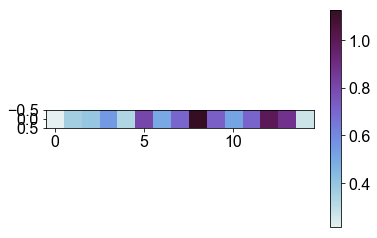

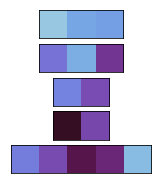

In [52]:
dff_mean=np.zeros((1,15))
dff_mean=np.array(resnoid.params[0:15]).reshape(1,15)
    
#plt.imshow(np.array(res4.params[30+31:30+31+14]).reshape(1,14), cmap='seismic',vmin=-0.18,vmax=+0.18)
plt.imshow(dff_mean, cmap=cmocean.cm.dense)
plt.colorbar()
plt.savefig('ColordffColorbar.svg')

fig, axs = plt.subplots(5, 1, figsize=(10, 3))
i=0
for ax, interp in zip(axs, [3,6,8,10,15]):
    OneLobe=dff_mean[0,range(i,interp)].reshape(1,interp-i)
    ax.imshow(OneLobe, cmap=cmocean.cm.dense, vmin=0,vmax=max(abs(dff_mean.T)))
    ax.grid(False)
    #ax.axis('off')
    ax.xaxis.set_ticks_position('none') 
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.yaxis.set_ticks_position('none')  
    i=interp

plt.show()
fig.savefig('ColorDff.svg')

In [53]:
resAllmm.params[len(resAllmm.params)-16:len(resAllmm.params)-1]

starved:lobe[a1]     0.068746
starved:lobe[a2]    -0.001412
starved:lobe[a3]    -0.001223
starved:lobe[ap1]    0.004533
starved:lobe[ap2]   -0.012482
starved:lobe[ap3]   -0.010488
starved:lobe[b1]     0.118216
starved:lobe[b2]     0.061447
starved:lobe[bp1]    0.113562
starved:lobe[bp2]    0.052324
starved:lobe[g1]     0.038708
starved:lobe[g2]    -0.006890
starved:lobe[g3]    -0.020789
starved:lobe[g4]     0.017980
starved:lobe[g5]     0.005416
dtype: float64

In [54]:
resnoid.params[len(resAllmm.params)-16:len(resAllmm.params)-1]

lobe[a1]:starved     0.067622
lobe[a2]:starved    -0.002536
lobe[a3]:starved    -0.002347
lobe[ap1]:starved    0.003409
lobe[ap2]:starved   -0.013606
lobe[ap3]:starved   -0.011612
lobe[b1]:starved     0.117092
lobe[b2]:starved     0.060323
lobe[bp1]:starved    0.112438
lobe[bp2]:starved    0.051200
lobe[g1]:starved     0.037584
lobe[g2]:starved    -0.008014
lobe[g3]:starved    -0.021913
lobe[g4]:starved     0.016856
lobe[g5]:starved     0.004292
dtype: float64

In [55]:
result_reg.params[len(resAllmm.params)-16:len(resAllmm.params)-1]

starved:lobe[a1]     0.067776
starved:lobe[a2]    -0.003203
starved:lobe[a3]    -0.002628
starved:lobe[ap1]    0.003773
starved:lobe[ap2]   -0.014415
starved:lobe[ap3]   -0.012393
starved:lobe[b1]     0.117702
starved:lobe[b2]     0.060844
starved:lobe[bp1]    0.113202
starved:lobe[bp2]    0.051852
starved:lobe[g1]     0.038468
starved:lobe[g2]    -0.006745
starved:lobe[g3]    -0.020367
starved:lobe[g4]     0.018876
starved:lobe[g5]     0.004997
dtype: float64

In [56]:
resstarved.params[len(resstarved.params)-15:len(resstarved.params)]

lobe[a1]:starved     0.062888
lobe[a2]:starved    -0.024186
lobe[a3]:starved    -0.006774
lobe[ap1]:starved   -0.024195
lobe[ap2]:starved   -0.030887
lobe[ap3]:starved   -0.006875
lobe[b1]:starved     0.129547
lobe[b2]:starved     0.054449
lobe[bp1]:starved    0.078370
lobe[bp2]:starved    0.101336
lobe[g1]:starved     0.054975
lobe[g2]:starved    -0.027469
lobe[g3]:starved     0.024663
lobe[g4]:starved     0.094788
lobe[g5]:starved     0.027027
dtype: float64

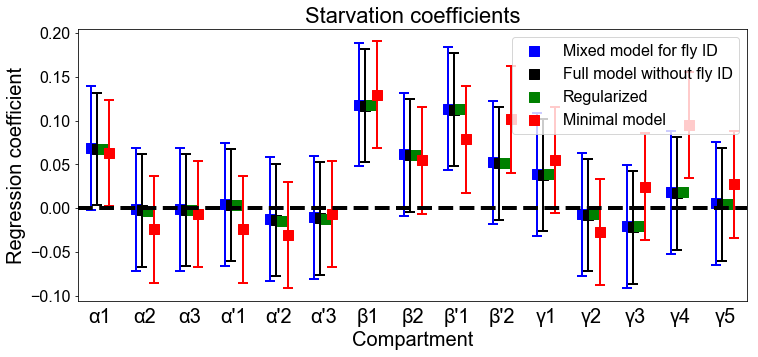

In [57]:
fig, ax = plt.subplots(figsize=(12, 5))
offset = lambda p: transforms.ScaledTranslation(p/72.,0, plt.gcf().dpi_scale_trans)
trans = plt.gca().transData

###################3

err_series = resAllmm.params - resAllmm.conf_int(alpha=0.02)[0]
coef_df = pd.DataFrame({'coef': resAllmm.params[len(resAllmm.params)-16:len(resAllmm.params)-1],
                       'err': err_series.values[len(resAllmm.params)-16:len(resAllmm.params)-1],
                       'varname': err_series.index.values[len(resAllmm.params)-16:len(resAllmm.params)-1]
                      })


coef_df.plot(x='varname', y='coef', kind='bar', 
            ax=ax, color='none', 
            yerr='err', 
            error_kw=dict(ecolor='blue', lw=2, capsize=5, capthick=2,transform=trans+offset(-9)),
            label='')

ax.scatter(x=pd.np.arange(coef_df.shape[0]), 
          marker='s', s=120,transform=trans+offset(-9), 
          y=coef_df['coef'], color='blue',label="Mixed model for fly ID")

##################3
err_series = resnoid.params - resnoid.conf_int(alpha=0.02)[0]
coef_df = pd.DataFrame({'coef': resnoid.params[len(resAllmm.params)-16:len(resAllmm.params)-1],
                        'err': err_series.values[len(resAllmm.params)-16:len(resAllmm.params)-1],
                        'varname': err_series.index.values[len(resAllmm.params)-16:len(resAllmm.params)-1]
                       })


coef_df.plot(x='varname', y='coef', kind='bar', 
             ax=ax, color='none', 
             yerr='err',
             error_kw=dict(ecolor='black', lw=2, capsize=5, capthick=2,transform=trans+offset(-3)),
             label='')

ax.scatter(x=pd.np.arange(coef_df.shape[0]), 
           marker='s', s=120, transform=trans+offset(-3),
           y=coef_df['coef'], color='black',label="Full model without fly ID")
######################

#err_series = result_reg.params - result_reg.conf_int()[0]
coef_df = pd.DataFrame({'coef': result_reg.params[len(resAllmm.params)-16:len(resAllmm.params)-1],
                        #'err': err_series.values[0:15],
                        #'varname': err_series.index.values[0:15]
                       })
coef_df.plot(y='coef', kind='bar', 
             ax=ax, color='None',label='')

ax.scatter(x=pd.np.arange(coef_df.shape[0]), 
           marker='s', s=120,transform=trans+offset(3),
           y=coef_df['coef'], color='Green',label="Regularized")
##################

err_series = resstarved.params - resstarved.conf_int(alpha=0.02)[0]
coef_df = pd.DataFrame({'coef': resstarved.params[len(resstarved.params)-15:len(resstarved.params)],
                        'err': err_series.values[len(resstarved.params)-15:len(resstarved.params)],
                        'varname': err_series.index.values[len(resstarved.params)-15:len(resstarved.params)]
                       })


coef_df.plot(x='varname', y='coef', kind='bar', 
             ax=ax, color='None', 
             yerr='err', 
             error_kw=dict(ecolor='red', lw=2, capsize=5, capthick=2,transform=trans+offset(9)),
             label='')

ax.set_ylabel('Regression coefficient', fontsize=20)
ax.set_xlabel('Compartment', fontsize=20)

ax.scatter(x=pd.np.arange(coef_df.shape[0]), 
           marker='s', s=100, transform=trans+offset(9),
           y=coef_df['coef'], color='red',label="Minimal model")

ax.axhline(y=0, linestyle='--', color='black', linewidth=4)
ax.xaxis.set_ticks_position('none')
_ = ax.set_xticklabels(LobesGreek, 
                       rotation=0, fontsize=20)

ax.set_title("Starvation coefficients", fontsize=22)
leg = ax.legend(loc='upper right', fancybox=True, fontsize=16)

plt.show()
fig.savefig('StarvationCoefficients_98CI.svg')

['a1' 'a2' 'a3' 'ap1' 'ap2' 'ap3' 'b1' 'b2' 'bp1' 'bp2' 'g1' 'g2' 'g3'
 'g4' 'g5']


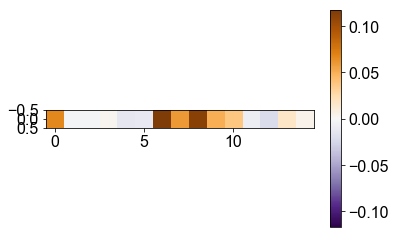

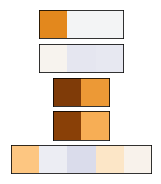

In [58]:
print(lobes)
LobeValues=np.array(resnoid.params[len(resnoid.params)-15:len(resnoid.params)]).reshape(1,15)
Vmax=max(abs(LobeValues.T))
plt.imshow(LobeValues,cmap='PuOr_r',vmin=-Vmax,vmax=Vmax)
plt.colorbar()
plt.savefig('ColorHungerBar.svg')
fig, axs = plt.subplots(5, 1, figsize=(10, 3))
i=0
for ax, interp in zip(axs, [3,6,8,10,15]):
    OneLobe=LobeValues[0,range(i,interp)].reshape(1,interp-i)
    ax.imshow(OneLobe,cmap='PuOr_r',vmin=-Vmax,vmax=Vmax)
    ax.grid(False)
    #ax.axis('off')
    ax.xaxis.set_ticks_position('none') 
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.yaxis.set_ticks_position('none')  
    i=interp

plt.show()
fig.savefig('ColorHunger.svg')

## Stimulus reduced to valence

As odors with well-defined valence represent a subset of the data, we treat it separately

In [59]:
data_val=lobe_data[np.abs(lobe_data.valence)==1]

In [60]:
resval = smf.ols(formula="df_f ~ lobe*(starved+order_presented+dorsal_to_ventral_val)+valence:lobe-1", data=data_val).fit()
resval.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   df_f   R-squared:                       0.320
Model:                            OLS   Adj. R-squared:                  0.301
Method:                 Least Squares   F-statistic:                     16.34
Date:                Mon, 09 Mar 2020   Prob (F-statistic):          5.05e-163
Time:                        16:45:27   Log-Likelihood:                -1387.4
No. Observations:                2640   AIC:                             2925.
Df Residuals:                    2565   BIC:                             3366.
Df Model:                          74                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
lobe[a1]                              0.0740      0.057      1.291      0.197      -0.038       0.186
lobe[a2]                              0.3596      0.057      6.274      0.000       0.247       0.472
lobe[a3]                              0.3421      0.057      5.969      0.000       0.230       0.454
lobe[ap1]                             0.4033      0.057      7.038      0.000       0.291       0.516
lobe[ap2]                             0.3863      0.057      6.740      0.000       0.274       0.499
lobe[ap3]                             0.9256      0.057     16.151      0.000       0.813       1.038
lobe[b1]                              0.4456      0.057      7.776      0.000       0.333       0.558
lobe[b2]                              0.6505      0.057     11.352      0.000       0.538       0.763
lobe[bp1]                             0.9104      0.057     15.887      0.000       0.798       1.023
lobe[bp2]                             0.7171      0.057     12.514      0.000       0.605       0.830
lobe[g1]                              0.3170      0.057      5.532      0.000       0.205       0.429
lobe[g2]                              0.4640      0.057      8.097      0.000       0.352       0.576
lobe[g3]                              0.6820      0.057     11.901      0.000       0.570       0.794
lobe[g4]                              0.6483      0.057     11.313      0.000       0.536       0.761
lobe[g5]                              0.2042      0.057      3.563      0.000       0.092       0.317
starved                               0.0468      0.038      1.219      0.223      -0.028       0.122
lobe[T.a2]:starved                   -0.0364      0.054     -0.670      0.503      -0.143       0.070
lobe[T.a3]:starved                   -0.0454      0.054     -0.837      0.403      -0.152       0.061
lobe[T.ap1]:starved                  -0.0342      0.054     -0.631      0.528      -0.141       0.072
lobe[T.ap2]:starved                  -0.0642      0.054     -1.184      0.237      -0.171       0.042
lobe[T.ap3]:starved                   0.0362      0.054      0.667      0.505      -0.070       0.143
lobe[T.b1]:starved                   -0.0015      0.054     -0.027      0.978      -0.108       0.105
lobe[T.b2]:starved                   -0.0201      0.054     -0.370      0.711      -0.127       0.086
lobe[T.bp1]:starved                   0.0704      0.054      1.297      0.195      -0.036       0.177
lobe[T.bp2]:starved                  -0.0004      0.054     -0.007      0.994      -0.107       0.106
lobe[T.g1]:starved                    0.0071      0.054      0.130      0.897      -0.099       0.113
lobe[T.g2]:starved                   -0.0704      0.054     -1.298      0.194      -0.177       0.036
lobe[T.g3]:starved     

In [61]:
resvalforanova = smf.ols(formula="df_f ~ lobe*(valence+order_presented+dorsal_to_ventral_val+starved)", data=data_val).fit()
resvalforanova.summary()
aov_table = anova_lm(resvalforanova, typ=2)
print(resval.rsquared)
print(100*(aov_table.sum_sq.values[1]+aov_table.sum_sq.values[2])/sum(aov_table.sum_sq.values))
aov_table

0.3203166932207123
3.3055967034297886


,sum_sq,df,F,PR(>F)
lobe,173.784193,14.0,72.008130,7.551609e-173
valence,0.503423,1.0,2.920331,8.759089e-02
lobe:valence,20.972820,14.0,8.690166,9.263294e-19
order_presented,0.771050,1.0,4.472824,3.453422e-02
lobe:order_presented,0.998133,14.0,0.413580,9.713488e-01
dorsal_to_ventral_val,1.053684,1.0,6.112370,1.348832e-02
lobe:dorsal_to_ventral_val,4.630301,14.0,1.918583,2.054316e-02
starved,2.219182,1.0,12.873367,3.395292e-04
lobe:starved,2.591797,14.0,1.073921,3.763775e-01
Residual,442.168779,2565.0,NaN,NaN


In [63]:
resInterVal = smf.ols(formula="df_f ~ lobe*(stimulus+order_presented+dorsal_to_ventral_val+starved)", data=data_val).fit()
aov_table = anova_lm(resInterVal, typ=2)
print(resInterVal.rsquared)
print(100*(aov_table.sum_sq.values[1]+aov_table.sum_sq.values[2])/sum(aov_table.sum_sq.values))
aov_table

0.3718533010627132
8.456755055773113


,sum_sq,df,F,PR(>F)
lobe,173.784193,14.0,76.549124,4.944171e-182
stimulus,18.741473,4.0,28.893605,1.629187e-23
lobe:stimulus,36.261970,56.0,3.993203,9.984365e-21
order_presented,0.987547,1.0,6.089981,1.366104e-02
lobe:order_presented,1.197381,14.0,0.527427,9.185988e-01
dorsal_to_ventral_val,1.265153,1.0,7.801910,5.258530e-03
lobe:dorsal_to_ventral_val,4.247889,14.0,1.871126,2.497386e-02
starved,2.300513,1.0,14.186742,1.693226e-04
lobe:starved,2.980682,14.0,1.312942,1.909572e-01
Residual,408.641578,2520.0,NaN,NaN


In [64]:
resvalmm = smf.mixedlm(formula="df_f ~ lobe*(starved+order_presented+dorsal_to_ventral_val)+valence:lobe-1", data=data_val, groups=data_val["fly_id"]).fit()

In [65]:
resval_reg = smf.ols(formula="df_f~ lobe*(starved+order_presented+dorsal_to_ventral_val)+valence:lobe-1", data=data_val).fit_regularized()

In [66]:
resonlyval = smf.ols(formula="df_f ~ lobe+lobe:valence-1", data=data_val).fit()

In [67]:
resnostim = smf.ols(formula="df_f ~lobe*(starved+order_presented+dorsal_to_ventral_val)-1",data=data_val).fit()

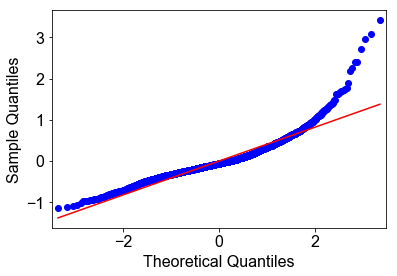

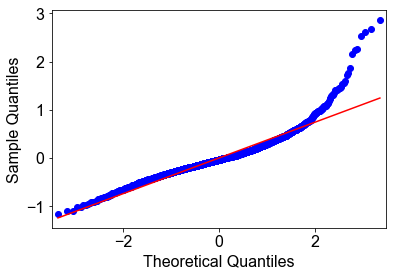

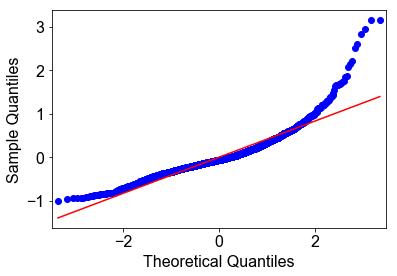

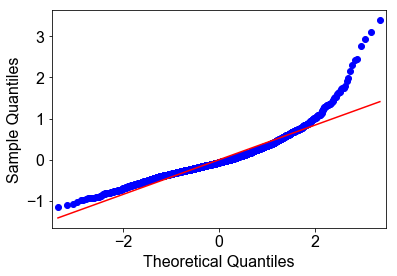

In [68]:
residuals = resval.resid 
fig = smapi.qqplot(residuals, line='s')
residuals = resvalmm.resid 
fig = smapi.qqplot(residuals, line='s')
residuals = resonlyval.resid 
fig = smapi.qqplot(residuals, line='s')
residuals = resnostim.resid 
fig = smapi.qqplot(residuals, line='s')
plt.show()

In [69]:
formulastim="df_f ~ lobe*(starved+order_presented+dorsal_to_ventral_val)+valence:lobe-1"
cv_ols_stim = cross_val_score(SMFormulaWrapper(smf.ols, formulastim),data_val,data_val['df_f'],scoring='explained_variance', cv=6)
print ("Everything with valence "+str(np.mean(cv_ols_stim))+" Rsquare:"+str(resval.rsquared))

formulavalenceonly="df_f ~lobe+lobe:valence-1"
cv_ols_valenceonly = cross_val_score(SMFormulaWrapper(smf.ols, formulavalenceonly),data_val,data_val['df_f'],scoring='explained_variance', cv=6)
print ("Only valence and lobe: cross validated "+str(np.mean(cv_ols_valenceonly))+" Rsquare:"+str(resonlyval.rsquared))

NoStim="df_f ~lobe*(starved+order_presented+dorsal_to_ventral_val)-1"
cv_ols_nostim= cross_val_score(SMFormulaWrapper(smf.ols, NoStim),data_val,data_val['df_f'],scoring='explained_variance', cv=6)
print ("No stimulus info: cross validated "+str(np.mean(cv_ols_nostim))+" Rsquare:"+str(resnostim.rsquared))



Everything with valence 0.2648454286479331 Rsquare:0.3203166932207123
Only valence and lobe: cross validated 0.287991051885458 Rsquare:0.30068711859976327
No stimulus info: cross validated 0.24266237974393087 Rsquare:0.2873043140356192


In [70]:
print(resval.aic,resval.bic)
print(resonlyval.aic,resonlyval.bic)
print(resnostim.aic,resnostim.bic)

2924.7311665351135 3365.6212312456405
2909.8953737166676 3086.2513996008784
3019.9399171205305 3372.651968888952


In this case, the minimal model seems the more reliable

In [71]:
print('Parameters: ', resval.params[len(resval.params)-15:len(resval.params)])

Parameters:  valence:lobe[a1]    -0.018798
valence:lobe[a2]    -0.036899
valence:lobe[a3]    -0.090915
valence:lobe[ap1]   -0.101921
valence:lobe[ap2]   -0.036207
valence:lobe[ap3]    0.030989
valence:lobe[b1]     0.071144
valence:lobe[b2]     0.129182
valence:lobe[bp1]   -0.033389
valence:lobe[bp2]    0.137962
valence:lobe[g1]     0.001627
valence:lobe[g2]    -0.090814
valence:lobe[g3]    -0.014920
valence:lobe[g4]     0.220156
valence:lobe[g5]     0.040892
dtype: float64


In [72]:
print('Parameters: ', resvalmm.params[len(resvalmm.params)-16:len(resvalmm.params)-1])

Parameters:  valence:lobe[a1]     0.011708
valence:lobe[a2]    -0.006393
valence:lobe[a3]    -0.060410
valence:lobe[ap1]   -0.071415
valence:lobe[ap2]   -0.005702
valence:lobe[ap3]    0.061495
valence:lobe[b1]     0.101650
valence:lobe[b2]     0.159687
valence:lobe[bp1]   -0.002884
valence:lobe[bp2]    0.168468
valence:lobe[g1]     0.032133
valence:lobe[g2]    -0.060308
valence:lobe[g3]     0.015586
valence:lobe[g4]     0.250662
valence:lobe[g5]     0.071398
dtype: float64


In [73]:
print('Parameters: ', resonlyval.params[len(resonlyval.params)-15:len(resonlyval.params)])

Parameters:  lobe[a1]:valence    -0.017161
lobe[a2]:valence    -0.037265
lobe[a3]:valence    -0.091874
lobe[ap1]:valence   -0.102049
lobe[ap2]:valence   -0.037350
lobe[ap3]:valence    0.031122
lobe[b1]:valence     0.074071
lobe[b2]:valence     0.130007
lobe[bp1]:valence   -0.031770
lobe[bp2]:valence    0.138506
lobe[g1]:valence     0.002916
lobe[g2]:valence    -0.091399
lobe[g3]:valence    -0.014258
lobe[g4]:valence     0.219880
lobe[g5]:valence     0.040543
dtype: float64


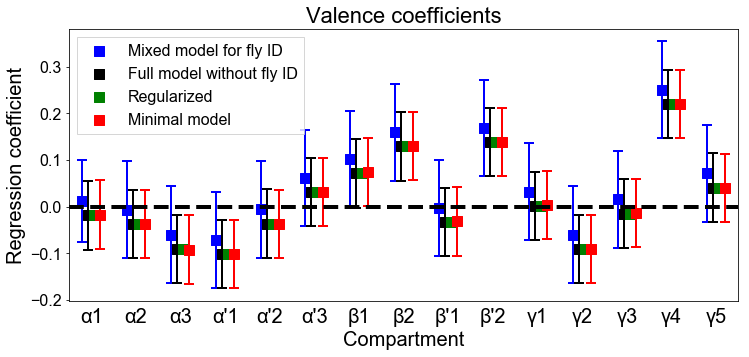

In [74]:
fig, ax = plt.subplots(figsize=(12, 5))
offset = lambda p: transforms.ScaledTranslation(p/72.,0, plt.gcf().dpi_scale_trans)
trans = plt.gca().transData

##################3
err_series = resvalmm.params - resval.conf_int(alpha=0.02)[0]
coef_df = pd.DataFrame({'coef': resvalmm.params[len(resvalmm.params)-16:len(resvalmm.params)-1],
                        'err': err_series.values[len(resvalmm.params)-16:len(resvalmm.params)-1],
                        'varname': err_series.index.values[len(resvalmm.params)-16:len(resvalmm.params)-1]
                       })


coef_df.plot(x='varname', y='coef', kind='bar', 
             ax=ax, color='none', 
             yerr='err',
             error_kw=dict(ecolor='blue', lw=2, capsize=5, capthick=2,transform=trans+offset(-9)),
             label='')

ax.scatter(x=pd.np.arange(coef_df.shape[0]), 
           marker='s', s=120, transform=trans+offset(-9),
           y=coef_df['coef'], color='blue',label="Mixed model for fly ID")
##################3
err_series = resval.params - resval.conf_int(alpha=0.02)[0]
coef_df = pd.DataFrame({'coef': resval.params[len(resval.params)-15:len(resval.params)],
                        'err': err_series.values[len(resval.params)-15:len(resval.params)],
                        'varname': err_series.index.values[len(resval.params)-15:len(resval.params)]
                       })


coef_df.plot(x='varname', y='coef', kind='bar', 
             ax=ax, color='none', 
             yerr='err',
             error_kw=dict(ecolor='black', lw=2, capsize=5, capthick=2,transform=trans+offset(-3)),
             label='')

ax.scatter(x=pd.np.arange(coef_df.shape[0]), 
           marker='s', s=120, transform=trans+offset(-3),
           y=coef_df['coef'], color='black',label="Full model without fly ID")
######################

#err_series = result_reg.params - result_reg.conf_int()[0]
coef_df = pd.DataFrame({'coef': resval_reg.params[len(resval.params)-15:len(resval.params)],
                        #'err': err_series.values[0:15],
                        #'varname': err_series.index.values[0:15]
                       })
coef_df.plot(y='coef', kind='bar', 
             ax=ax, color='None',label='')

ax.scatter(x=pd.np.arange(coef_df.shape[0]), 
           marker='s', s=120,transform=trans+offset(3),
           y=coef_df['coef'], color='Green',label="Regularized")
##################

err_series = resonlyval.params - resonlyval.conf_int(alpha=0.02)[0]
coef_df = pd.DataFrame({'coef': resonlyval.params[len(resonlyval.params)-15:len(resonlyval.params)],
                        'err': err_series.values[len(resonlyval.params)-15:len(resonlyval.params)],
                        'varname': err_series.index.values[len(resonlyval.params)-15:len(resonlyval.params)]
                       })


coef_df.plot(x='varname', y='coef', kind='bar', 
             ax=ax, color='None', 
             yerr='err', 
             error_kw=dict(ecolor='red', lw=2, capsize=5, capthick=2,transform=trans+offset(9)),
             label='')

ax.set_ylabel('Regression coefficient', fontsize=20)
ax.set_xlabel('Compartment', fontsize=20)

ax.scatter(x=pd.np.arange(coef_df.shape[0]), 
           marker='s', s=100, transform=trans+offset(9),
           y=coef_df['coef'], color='red',label="Minimal model")
ax.set_ylabel('Regression coefficient', fontsize=20)
ax.set_xlabel('Compartment', fontsize=20)

# ax.scatter(x=pd.np.arange(coef_df.shape[0]), 
#            marker='s', s=120, 
#            y=coef_df['coef'], 
#            color='Red',label='Minimal model')

ax.axhline(y=0, linestyle='--', color='black', linewidth=4)
ax.xaxis.set_ticks_position('none')
_ = ax.set_xticklabels(LobesGreek, 
                       rotation=0, fontsize=20)

#ax.set_ylim([-0.2,0.6])
ax.set_title("Valence coefficients", fontsize=22)
leg = ax.legend(loc='upper left', fancybox=False, fontsize=16)
plt.show()
fig.savefig('ValenceCoefficients_98CI.svg')

['a1' 'a2' 'a3' 'ap1' 'ap2' 'ap3' 'b1' 'b2' 'bp1' 'bp2' 'g1' 'g2' 'g3'
 'g4' 'g5']


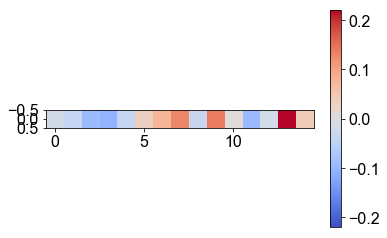

In [75]:
#Valence pos
print(lobes)
#plt.imshow(np.array(res4.params[30+31:30+31+14]).reshape(1,14), cmap='seismic',vmin=-0.18,vmax=+0.18)
LobeValues=np.array(resonlyval.params[len(resonlyval.params)-15:len(resonlyval.params)]).reshape(1,15)
plt.imshow(LobeValues, cmap='coolwarm', vmin=-max(abs(LobeValues.T)),vmax=max(abs(LobeValues.T)))
plt.colorbar()
plt.savefig('ColorValenceColorbarVrev.svg')

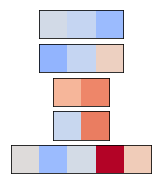

In [76]:
fig, axs = plt.subplots(5, 1, figsize=(10, 3))
i=0
for ax, interp in zip(axs, [3,6,8,10,15]):
    OneLobe=LobeValues[0,range(i,interp)].reshape(1,interp-i)
    ax.imshow(OneLobe,cmap='coolwarm', vmin=-max(abs(LobeValues.T)),vmax=max(abs(LobeValues.T)))
    ax.grid(False)
    #ax.axis('off')
    ax.xaxis.set_ticks_position('none') 
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.yaxis.set_ticks_position('none')  
    i=interp

plt.show()
fig.savefig('ColorValenceVrev.svg')

# Interaction between starvation and valence

In [107]:
resStarvVal = smf.ols(formula="df_f ~ lobe*hours_starved*valence", data=data_val).fit()
aov_table = anova_lm(resStarvVal, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
lobe,173.784193,14.0,71.473594,7.551953e-172
hours_starved,2.710955,1.0,15.609381,7.995578e-05
lobe:hours_starved,2.853494,14.0,1.173579,2.886317e-01
valence,0.424843,1.0,2.446198,1.179325e-01
lobe:valence,20.965138,14.0,8.622497,1.384766e-18
hours_starved:valence,0.117376,1.0,0.675838,4.110996e-01
lobe:hours_starved:valence,1.176214,14.0,0.483751,9.428830e-01
Residual,448.080784,2580.0,NaN,NaN


In [91]:
esum = dd.io.load("experiments_summary.h5")
lobe_data= pd.DataFrame(esum["lobe_summary"])
lobe_activities = np.row_stack(esum["df_fs"])
lobe_data["df_f"] = np.mean(lobe_activities[:, 31:35], 1)

lobe_data_vin=lobe_data[lobe_data["stimulus"].isin({"Vinegar","high_Vinegar"})].reset_index(drop=True)
lobe_data_vin_st=lobe_data_vin[lobe_data_vin["hours_starved"]!=0].reset_index(drop=True)
lobe_data_vin_fd=lobe_data_vin[lobe_data_vin["hours_starved"]==0].reset_index(drop=True)

SamplesVinSt=int(len(lobe_data_vin_st)/15)
SamplesVinFd=int(len(lobe_data_vin_fd)/15)

lobe_data=lobe_data[lobe_data["stimulus"]!="high_Vinegar"]

Lobe_mean_activity_matrix_vin_st=np.zeros((SamplesVinSt,15))
#Lobe_odor_tensor=np.zeros((107,15,80))
for i in range(SamplesVinSt):
    for j in range(15):
        Lobe_mean_activity_matrix_vin_st[i,j]=lobe_data_vin_st["df_f"][i*15+j]        
        #Lobe_odor_tensor[i,j,:]=lobe_activities[i*15+j,:] 
        #print(lobe_data["lobe"][i*15+j])
Lobe_mean_activity_matrix_vin_fd=np.zeros((SamplesVinFd,15))
#Lobe_odor_tensor=np.zeros((107,15,80))
for i in range(SamplesVinFd):
    for j in range(15):
        Lobe_mean_activity_matrix_vin_fd[i,j]=lobe_data_vin_fd["df_f"][i*15+j]        
        #Lobe_odor_tensor[i,j,:]=lobe_activities[i*15+j,:] 
        #print(lobe_data["lobe"][i*15+j])

In [100]:
# Projections on coefficients
Xproj_Fed = np.inner(LobeValues,Lobe_mean_activity_matrix_vin_fd)
Xproj_St = np.inner(LobeValues,Lobe_mean_activity_matrix_vin_st)

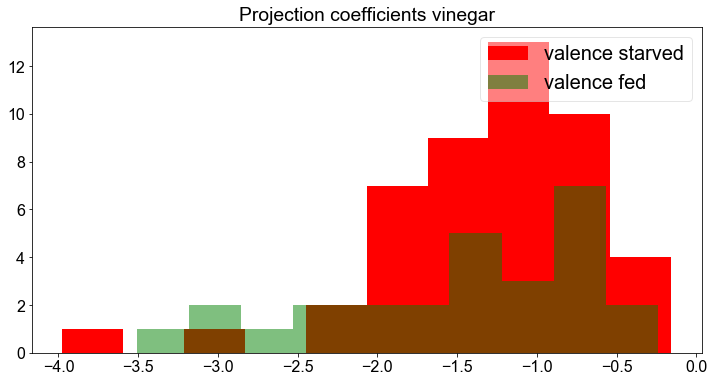

In [104]:
import math

#min_b = math.floor(np.min(Xval_lda_fd))
#max_b = math.ceil(np.max(X_lda_st))
#bins = np.linspace(min_b, max_b, 25)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
ax.hist(Xproj_St.T,
                color='r',
                label="valence "+"starved",
                #bins=bins,
                #alpha=0.5
       )
ax.hist(Xproj_Fed.T,
                color='g',
                label="valence "+"fed",
                #bins=bins,
                alpha=0.5)
    # plot annotation
leg = ax.legend(loc='upper right', fancybox=True, fontsize=20)
leg.get_frame().set_alpha(0.5)
ax.set_title('Projection coefficients vinegar')

plt.show()

## Mating

In [79]:
# Tried to put it in the big model but tends to overfit. We know that mating was only avaluated with cVA,Fed, and different flies. It needs another model. The starvation/stimulus data should be independant. Only the lobes should be shared.
resmated = smf.ols(formula="df_f ~lobe+virgin_val", data=lobe_data[lobe_data.stimulus=="cVA"]).fit()
resmated.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   df_f   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     26.71
Date:                Mon, 09 Mar 2020   Prob (F-statistic):           3.69e-63
Time:                        16:47:12   Log-Likelihood:                -555.49
No. Observations:                1020   AIC:                             1143.
Df Residuals:                    1004   BIC:                             1222.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.1725      0.052      3.298      0.001       0.070       0.275
lobe[T.a2]      0.3599      0.072      4.991      0.000       0.218       0.501
lobe[T.a3]      0.3059      0.072      4.243      0.000       0.164       0.447
lobe[T.ap1]     0.4678      0.072      6.488      0.000       0.326       0.609
lobe[T.ap2]     0.3395      0.072      4.708      0.000       0.198       0.481
lobe[T.ap3]     0.7414      0.072     10.282      0.000       0.600       0.883
lobe[T.b1]      0.1932      0.072      2.679      0.008       0.052       0.335
lobe[T.b2]      0.5243      0.072      7.272      0.000       0.383       0.666
lobe[T.bp1]     0.9877      0.072     13.698      0.000       0.846       1.129
lobe[T.bp2]     0.3018      0.072      4.185      0.000       0.160       0.443
lobe[T.g1]      0.1969      0.072      2.731      0.006       0.055       0.338
lobe[T.g2]      0.4644      0.072      6.441      0.000       0.323       0.606
lobe[T.g3]      0.4920      0.072      6.823      0.000       0.351       0.634
lobe[T.g4]      0.1694      0.072      2.350      0.019       0.028       0.311
lobe[T.g5]     -0.0322      0.072     -0.447      0.655      -0.174       0.109
virgin_val     -0.1219      0.027     -4.599      0.000      -0.174      -0.070
==============================================================================
Omnibus:                      491.172   Durbin-Watson:                   1.331
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4534.798
Skew:                           1.994   Prob(JB):                         0.00
Kurtosis:                      12.529   Cond. No.                         17.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [111]:
# Tried to put it in the big model but tends to overfit. We know that mating was only avaluated with cVA,Fed, and different flies. It needs another model. The starvation/stimulus data should be independant. Only the lobes should be shared.
resmatedbasic = smf.ols(formula="df_f ~ lobe+virgin", data=lobe_data[lobe_data.stimulus=="cVA"]).fit()
print(resmatedbasic.rsquared)
aov_table = anova_lm(resmatedbasic, typ=2)

print(100*(aov_table.sum_sq.values[1]+aov_table.sum_sq.values[2])/sum(aov_table.sum_sq.values))
aov_table

0.2852324807739045
72.98257916892804


,sum_sq,df,F,PR(>F)
lobe,67.086845,14.0,27.107206,1.279009e-60
virgin,3.739113,1.0,21.151640,4.784906e-06
Residual,177.483625,1004.0,NaN,NaN


In [89]:
# Tried to put it in the big model but tends to overfit. We know that mating was only avaluated with cVA,Fed, and different flies. It needs another model. The starvation/stimulus data should be independant. Only the lobes should be shared.
resmated = smf.ols(formula="df_f ~ lobe+lobe:virgin_val", data=lobe_data[lobe_data.stimulus=="cVA"]).fit()
resmated.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   df_f   R-squared:                       0.297
Model:                            OLS   Adj. R-squared:                  0.277
Method:                 Least Squares   F-statistic:                     14.45
Date:                Tue, 10 Mar 2020   Prob (F-statistic):           1.35e-57
Time:                        09:46:03   Log-Likelihood:                -546.72
No. Observations:                1020   AIC:                             1153.
Df Residuals:                     990   BIC:                             1301.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.1232      0.068      1.809      0.071      -0.010       0.257
lobe[T.a2]               0.4250      0.096      4.413      0.000       0.236       0.614
lobe[T.a3]               0.4022      0.096      4.176      0.000       0.213       0.591
lobe[T.ap1]              0.5102      0.096      5.297      0.000       0.321       0.699
lobe[T.ap2]              0.4061      0.096      4.217      0.000       0.217       0.595
lobe[T.ap3]              0.8718      0.096      9.052      0.000       0.683       1.061
lobe[T.b1]               0.1921      0.096      1.994      0.046       0.003       0.381
lobe[T.b2]               0.5431      0.096      5.639      0.000       0.354       0.732
lobe[T.bp1]              1.1515      0.096     11.957      0.000       0.963       1.341
lobe[T.bp2]              0.3312      0.096      3.439      0.001       0.142       0.520
lobe[T.g1]               0.1993      0.096      2.070      0.039       0.010       0.388
lobe[T.g2]               0.5194      0.096      5.394      0.000       0.330       0.708
lobe[T.g3]               0.5518      0.096      5.730      0.000       0.363       0.741
lobe[T.g4]               0.1843      0.096      1.914      0.056      -0.005       0.373
lobe[T.g5]              -0.0362      0.096     -0.376      0.707      -0.225       0.153
lobe[a1]:virgin_val     -0.0102      0.103     -0.099      0.921      -0.211       0.191
lobe[a2]:virgin_val     -0.1576      0.103     -1.538      0.124      -0.359       0.044
lobe[a3]:virgin_val     -0.2283      0.103     -2.227      0.026      -0.429      -0.027
lobe[ap1]:virgin_val    -0.1061      0.103     -1.034      0.301      -0.307       0.095
lobe[ap2]:virgin_val    -0.1613      0.103     -1.574      0.116      -0.363       0.040
lobe[ap3]:virgin_val    -0.3056      0.103     -2.981      0.003      -0.507      -0.104
lobe[b1]:virgin_val     -0.0076      0.103     -0.074      0.941      -0.209       0.194
lobe[b2]:virgin_val     -0.0527      0.103     -0.514      0.607      -0.254       0.148
lobe[bp1]:virgin_val    -0.3815      0.103     -3.721      0.000      -0.583      -0.180
lobe[bp2]:virgin_val    -0.0768      0.103     -0.750      0.454      -0.278       0.124
lobe[g1]:virgin_val     -0.0157      0.103     -0.153      0.878      -0.217       0.186
lobe[g2]:virgin_val     -0.1348      0.103     -1.315      0.189      -0.336       0.066
lobe[g3]:virgin_val     -0.1457      0.103     -1.421      0.155      -0.347       0.055
lobe[g4]:virgin_val     -0.0438      0.103     -0.427      0.669      -0.245       0.157
lobe[g5]:virgin_val     -0.0013      0.103     -0.012      0.990      -0.202       0.200
==============================================================================
Omnibus:                      488.268   Durbin-Watson:             

In [90]:
aov_table = anova_lm(resmated, typ=2)
print(resmated.rsquared)
print(100*(aov_table.sum_sq.values[1]+aov_table.sum_sq.values[2])/sum(aov_table.sum_sq.values))
aov_table

0.2974243301931714
72.982579168928


,sum_sq,df,F,PR(>F)
lobe,67.086845,14.0,27.193051,1.139738e-60
lobe:virgin_val,6.766466,15.0,2.559878,9.276729e-04
Residual,174.456272,990.0,NaN,NaN


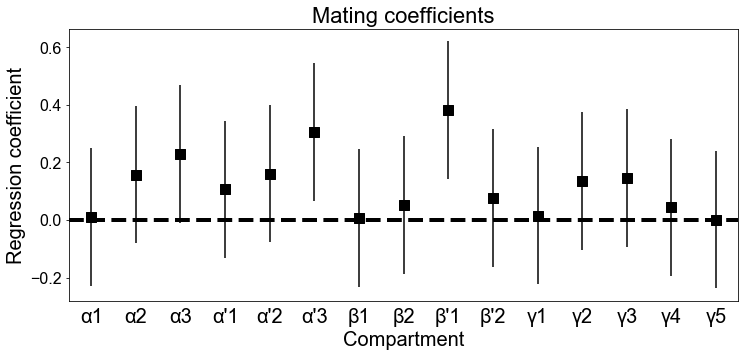

In [83]:
err_series = resmated.params - resmated.conf_int(alpha=0.02)[0]
coef_df = pd.DataFrame({'coef': -resmated.params.values[len(resmated.params)-15:len(resmated.params)],
                        'err': err_series.values[len(resmated.params)-15:len(resmated.params)],
                        'varname': err_series.index.values[len(resmated.params)-15:len(resmated.params)]
                       })

fig, ax = plt.subplots(figsize=(12, 5))
coef_df.plot(x='varname', y='coef', kind='bar', 
             ax=ax, color='none', 
             yerr='err', legend=False)

ax.set_ylabel('Regression coefficient', fontsize=20)
ax.set_xlabel('Compartment', fontsize=20)

ax.scatter(x=pd.np.arange(coef_df.shape[0]), 
           marker='s', s=120, 
           y=coef_df['coef'], color='black')

ax.axhline(y=0, linestyle='--', color='black', linewidth=4)
ax.xaxis.set_ticks_position('none')
_ = ax.set_xticklabels(LobesGreek, 
                       rotation=0, fontsize=20)
ax.set_title("Mating coefficients", fontsize=22)
plt.show()
fig.savefig('MatingCoefficients_98CI.svg')
fig.savefig('MatingCoefficients_98CI.png')

['a1' 'a2' 'a3' 'ap1' 'ap2' 'ap3' 'b1' 'b2' 'bp1' 'bp2' 'g1' 'g2' 'g3'
 'g4' 'g5']


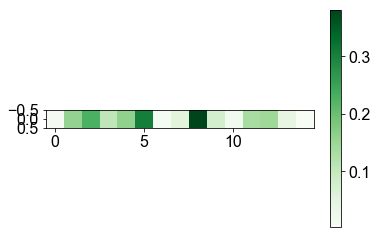

In [84]:
print(lobes)
#plt.imshow(np.array(res4.params[30+31:30+31+14]).reshape(1,14), cmap='seismic',vmin=-0.18,vmax=+0.18)
LobeValues=np.array(resmated.params[len(resmated.params)-15:len(resmated.params)]).reshape(1,15)
#LobeValues=np.array(resmated.params[len(resmated.params)-15:len(resmated.params)]).reshape(1,15)
plt.imshow(-LobeValues, cmap='Greens', vmin=min(-LobeValues.T),vmax=max(-LobeValues.T))
plt.colorbar()
plt.savefig('ColorMatedColorbar.svg')

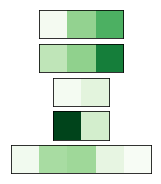

In [85]:
fig, axs = plt.subplots(5, 1, figsize=(10, 3))
i=0
for ax, interp in zip(axs, [3,6,8,10,15]):
    OneLobe=LobeValues[0,range(i,interp)].reshape(1,interp-i)
    ax.imshow(-OneLobe, cmap='Greens',vmin=min(-LobeValues.T),vmax=max(-LobeValues.T))
    ax.grid(False)
    #ax.axis('off')
    ax.xaxis.set_ticks_position('none') 
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.yaxis.set_ticks_position('none')  
    i=interp

plt.show()
fig.savefig('ColorMated.svg')

### Coefficients for Walking

Obtained from light field data sets

In [ ]:
Lobes_walk=[0.01066687, 0.00987809, 0.00954731, 0.01147492, 0.00766827,
       0.01444354, 0.03493431, 0.04012054, 0.04088321, 0.06068407,
       0.02333673, 0.02201726, 0.06849938, 0.07199122, 0.04716212]

In [ ]:
Lobes_walk=[0.01208396, 0.01098271, 0.00889423, 0.0117519 , 0.00874816,
       0.01574062, 0.03386783, 0.03481163, 0.03815243, 0.06247785,
       0.02198737, 0.02008468, 0.06142156, 0.07099943, 0.04798851]

In [ ]:
#Valence pos
print(lobes)
#plt.imshow(np.array(res4.params[30+31:30+31+14]).reshape(1,14), cmap='seismic',vmin=-0.18,vmax=+0.18)
LobeValues=np.array(Lobes_walk).reshape(1,15)
plt.imshow(LobeValues, cmap='Reds', vmin=0,vmax=np.max(LobeValues))
plt.colorbar()
plt.savefig('ColorWalkColorbar.svg')

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=(10, 3))
i=0
for ax, interp in zip(axs, [3,6,8,10,15]):
    OneLobe=LobeValues[0,range(i,interp)].reshape(1,interp-i)
    ax.imshow(OneLobe, cmap='Reds', vmin=0,vmax=max(LobeValues.T))
    ax.grid(False)
    #ax.axis('off')
    ax.xaxis.set_ticks_position('none') 
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.yaxis.set_ticks_position('none')  
    i=interp

plt.show()
fig.savefig('ColorWalk.svg')

# Taste

In [86]:
data_tastequi=pd.read_excel("Taste_data.xlsx",'quinine').transpose()

data_tastesuc=pd.read_excel("Taste_data.xlsx",'sucrose').transpose()

db1=data_tastesuc.stack().reset_index()

db2=data_tastequi.stack().reset_index()

#taste_mean=pd.concat([suc_mean,qui_mean], ignore_index=True, sort=False)

db2['taste']='quinine'
db1['taste']='sucrose'

data_taste = pd.concat([db1, db2], ignore_index=True, sort=False)

data_taste.columns = ['lobe', 'num','df_f','taste']

data_taste['df_f_norm']=0
data_taste['norm']=0

Nums=[170,110,29,177,176,173,188,151,174,175,168,170]

for taste in ['quinine', 'sucrose']:
    for i in Nums:
        if any((data_taste['num']==i) & (data_taste['taste']==taste)):
            subData=data_taste[data_taste['num']==i][data_taste['taste']==taste]
            Norm=np.float(subData[subData['lobe']=='Mean'].df_f)
            data_taste.loc[(data_taste['num']==i) & (data_taste['taste']==taste),'Mean']=Norm


data_taste.df_f_norm=data_taste.df_f/data_taste.norm

C:\Users\aimon\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\aimon\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\aimon\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\aimon\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\aimon\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\aimon\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\aimon\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match Da

In [87]:
# Tried to put it in the big model but tends to overfit. We know that mating was only avaluated with cVA,Fed, and different flies. It needs another model. The starvation/stimulus data should be independant. Only the lobes should be shared.
resTaste = smf.ols(formula="df_f~Mean+lobe+lobe:taste-1", data=data_taste).fit()
resTaste.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   df_f   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.673
Method:                 Least Squares   F-statistic:                     18.40
Date:                Mon, 09 Mar 2020   Prob (F-statistic):           6.10e-48
Time:                        16:55:57   Log-Likelihood:                 620.46
No. Observations:                 272   AIC:                            -1175.
Df Residuals:                     239   BIC:                            -1056.
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
lobe[Mean]                     -0.0004      0.009     -0.049      0.961      -0.018       0.017
lobe[a1]                       -0.0209      0.009     -2.209      0.028      -0.040      -0.002
lobe[a2]                       -0.0024      0.009     -0.251      0.802      -0.021       0.016
lobe[a3]                       -0.0079      0.011     -0.731      0.466      -0.029       0.013
lobe[ap1]                       0.0224      0.009      2.364      0.019       0.004       0.041
lobe[ap2]                       0.0014      0.009      0.151      0.880      -0.017       0.020
lobe[ap3]                      -0.0171      0.011     -1.571      0.118      -0.038       0.004
lobe[b1]                       -0.0142      0.009     -1.587      0.114      -0.032       0.003
lobe[b2]                        0.0037      0.009      0.416      0.678      -0.014       0.021
lobe[bp1]                       0.0033      0.009      0.352      0.726      -0.015       0.022
lobe[bp2]                       0.0187      0.009      1.970      0.050    9.42e-07       0.037
lobe[g1]                        0.0068      0.010      0.676      0.500      -0.013       0.027
lobe[g2]                        0.0203      0.009      2.146      0.033       0.002       0.039
lobe[g3]                       -0.0031      0.009     -0.323      0.747      -0.022       0.016
lobe[g4]                       -0.0116      0.009     -1.227      0.221      -0.030       0.007
lobe[g5]                        0.0008      0.009      0.087      0.931      -0.018       0.019
lobe[Mean]:taste[T.sucrose] -8.088e-05      0.012     -0.007      0.995      -0.024       0.024
lobe[a1]:taste[T.sucrose]       0.0117      0.013      0.911      0.363      -0.014       0.037
lobe[a2]:taste[T.sucrose]      -0.0210      0.013     -1.677      0.095      -0.046       0.004
lobe[a3]:taste[T.sucrose]      -0.0096      0.014     -0.675      0.501      -0.038       0.018
lobe[ap1]:taste[T.sucrose]     -0.0411      0.013     -3.205      0.002      -0.066      -0.016
lobe[ap2]:taste[T.sucrose]     -0.0251      0.013     -2.007      0.046      -0.050      -0.000
lobe[ap3]:taste[T.sucrose]     -0.0038      0.014     -0.265      0.791      -0.032       0.024
lobe[b1]:taste[T.sucrose]       0.0111      0.012      0.912      0.363      -0.013       0.035
lobe[b2]:taste[T.sucrose]       0.0396      0.012      3.266      0.001       0.016       0.063
lobe[bp1]:taste[T.sucrose]     -0.0180      0.013     -1.407      0.161      -0.043       0.007
lobe[bp2]:taste[T.sucrose]      0.0272      0.013      2.122      0.035       0.002       0.052
lobe[g1]:taste[T.sucrose]      -0.0318      0.014     -2.323      0.021      -0.059      -0.005
lobe[g2]:taste[T.sucrose]      -0.0319      0.013     -2.489      0.014      -0.057      -0.007
lobe[g3]:ta

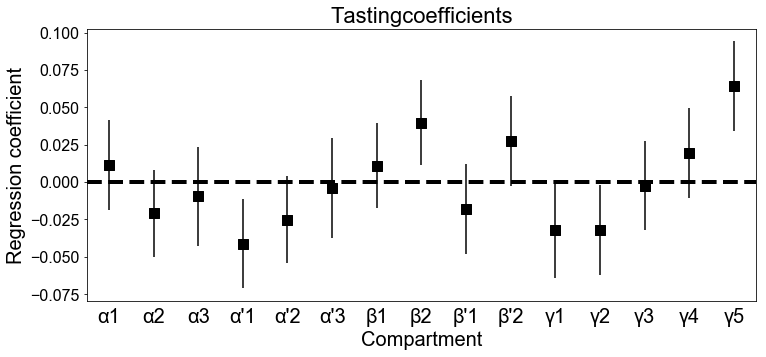

In [88]:
err_series = resTaste.params - resTaste.conf_int(alpha=0.02)[0]
coef_df = pd.DataFrame({'coef': resTaste.params.values[len(resTaste.params)-16:len(resTaste.params)-1],
                        'err': err_series.values[len(resTaste.params)-16:len(resTaste.params)-1],
                        'varname': err_series.index.values[len(resTaste.params)-16:len(resTaste.params)-1]
                       })

fig, ax = plt.subplots(figsize=(12, 5))
coef_df.plot(x='varname', y='coef', kind='bar', 
             ax=ax, color='none', 
             yerr='err', legend=False)

ax.set_ylabel('Regression coefficient', fontsize=20)
ax.set_xlabel('Compartment', fontsize=20)

ax.scatter(x=pd.np.arange(coef_df.shape[0]), 
           marker='s', s=120, 
           y=coef_df['coef'], color='black')

ax.axhline(y=0, linestyle='--', color='black', linewidth=4)
ax.xaxis.set_ticks_position('none')
_ = ax.set_xticklabels(LobesGreek, 
                       rotation=0, fontsize=20)
ax.set_title("Tastingcoefficients", fontsize=22)
plt.show()
fig.savefig('TastingCoefficients_98CI.svg')

In [ ]:
np.max(LobeValues)

In [ ]:
#plt.imshow(np.array(res4.params[30+31:30+31+14]).reshape(1,14), cmap='seismic',vmin=-0.18,vmax=+0.18)
LobeValues=np.array(resTaste.params[len(resTaste.params)-16:len(resTaste.params)-1]).reshape(1,15)
#LobeValues=np.array(resmated.params[len(resmated.params)-15:len(resmated.params)]).reshape(1,15)
Vmax=np.max([np.max(-LobeValues),np.max(LobeValues)])
plt.imshow(LobeValues, cmap='coolwarm', vmin=-Vmax,vmax=Vmax)
plt.colorbar()
plt.savefig('ColorTasteColorbar.svg')
fig, axs = plt.subplots(5, 1, figsize=(10, 3))
i=0
for ax, interp in zip(axs, [3,6,8,10,15]):
    OneLobe=LobeValues[0,range(i,interp)].reshape(1,interp-i)
    ax.imshow(OneLobe,cmap='coolwarm', vmin=-Vmax,vmax=Vmax)
    ax.grid(False)
    #ax.axis('off')
    ax.xaxis.set_ticks_position('none') 
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.yaxis.set_ticks_position('none')  
    i=interp

plt.show()
fig.savefig('ColorTaste.svg')

## Interactions between starvation and stimuli

In [ ]:
fig, ax = plt.subplots(figsize=(12, 5))

resnoidb = smf.ols(formula="df_f ~ stimulus:starved+lobe*(stimulus+order_presented+dorsal_to_ventral_val)+lobe:starved-1", data=lobe_data).fit()
Stimuli=[s[9:len(s)-9] for s in resnoidb.params.index.values[len(resnoidb.params)-56:len(resnoidb.params)-57+12]]

err_series = resnoidb.params - resnoidb.conf_int()[0]
coef_df = pd.DataFrame({'coef': resnoidb.params[len(resnoidb.params)-56:len(resnoidb.params)-57+12],
                        'err': err_series.values[len(resnoidb.params)-56:len(resnoidb.params)-57+12],
                        'varname': err_series.index.values[len(resnoidb.params)-56:len(resnoidb.params)-57+12]
                       })


coef_df.plot(x='varname', y='coef', kind='bar', 
             ax=ax, color='none', 
             yerr='err',  ecolor='blue',
             label="")

ax.scatter(x=pd.np.arange(coef_df.shape[0]), 
           marker='s', s=120, 
           y=coef_df['coef'],label="Full model no ID")

########
resstarvestim = smf.ols(formula="df_f ~ lobe+starved:stimulus", data=lobe_data).fit()

err_series = resstarvestim.params - resstarvestim.conf_int()[0]
coef_df = pd.DataFrame({'coef': resstarvestim.params[len(resstarvestim.params)-12:len(resstarvestim.params)-1],
                        'err': err_series.values[len(resstarvestim.params)-12:len(resstarvestim.params)-1],
                        'varname': err_series.index.values[len(resstarvestim.params)-12:len(resstarvestim.params)-1]
                       })


coef_df.plot(x='varname', y='coef', kind='bar', 
             ax=ax, color='none', 
             yerr='err', ecolor='orange',
             label="")

ax.scatter(x=pd.np.arange(coef_df.shape[0]), 
           marker='s', s=120, 
           y=coef_df['coef'],label="Minimal model")

ax.axhline(y=0, linestyle='--', color='black', linewidth=4)
ax.xaxis.set_ticks_position('none')

_ = ax.set_xticklabels(Stimuli, fontsize=20)
ax.set_title("Stimuli specific starvation coefficients", fontsize=22)
leg = ax.legend(loc='upper right', fancybox=True, fontsize=20)
ax.set_ylabel('Regression coefficient', fontsize=20)
ax.set_xlabel('Odor', fontsize=20)

plt.show()
fig.savefig('StimulivsStarvation.svg')

In [ ]:
resstarvestim.summary()

## Extra stuff

In [ ]:
#resadapt = smf.ols(formula="adaptnorm ~ C(lobe)*stimulus", data=lobe_data).fit()
#resadapt.summary()

In [ ]:
## Also play with mixed models in R

import rpy2
from rpy2.robjects import r, pandas2ri
pandas2ri.activate()

r_lobe_data = pandas2ri.py2ri(lobe_data)

%load_ext rpy2.ipython
%Rpush lobe_data

%%R

#library(lmerTest)
library(lme4)
#library(MuMIn) 
m_rt <- lmer(df_f ~ lobe*(order_presented+ dorsal_to_ventral)+lobe*stimulus+valence)+(1|valence)+(1|valence:lobe)+(lobe-1):hours_starved-1,data = lobe_data)

rfs <- ranef(m_rt)
ffs <- fixef(m_rt) 

# Jarret Byrnes (correlation between the fitted and the observed values)
r2.corr.mer <- function(m) {
   lmfit <-  lm(model.response(model.frame(m)) ~ fitted(m))
   summary(lmfit)$r.squared
}
r2.corr.mer(m_rt)

# Xu 2003
Res=1-var(residuals(m_rt))/(var(model.response(model.frame(m_rt))))

#Res=var(predict(mod1,newdata=lobe_data, re.form=~0))
Summixedmod=summary(m_rt)


# Nakagawa & Schielzeth's (2013)
#R2[2]=r.squaredGLMM(m_rt)

%%R
plot(m_rt)

%%R
library(lme4)

Summixedmod=summary(m_rt)
anovamixed=anova(m_rt)
capture.output(Summixedmod, file = "SummaryMixModel.txt")
capture.output(anovamixed, file = "anova results.txt")
capture.output(ffs, file = "Fixed.txt")
capture.output(rfs, file = "Random.txt")
capture.output(Res, file = "R2.txt")

Mixed models for valence and stimuli

In [ ]:
md = smf.mixedlm("df_f ~ lobe*(stimulus+order_presented+C(dorsal_to_ventral))+(lobe-1):hours_starved-1", lobe_data, groups=lobe_data["valence"],missing='drop')
mdf = md.fit()
print(mdf.summary())

In [ ]:
#Nested
vc = {'lv': 'lobe:valence'}
nestVal=smf.MixedLM.from_formula("df_f ~ lobe*(stimulus+order_presented+C(dorsal_to_ventral))+(lobe-1):hours_starved-1", vc_formula=vc,re_formula='1', groups='valence', data=lobe_data,missing='drop').fit()

print(nestVal.summary())

sum((mdf.predict(lobe_data[np.logical_or(lobe_data["valence"]==1,lobe_data["valence"]==-1)])-np.mean(mdf.predict(lobe_data[np.logical_or(lobe_data["valence"]==1,lobe_data["valence"]==-1)])))**2)/sum((lobe_data[np.logical_or(lobe_data["valence"]==1,lobe_data["valence"]==-1)]['df_f']-np.mean(lobe_data[np.logical_or(lobe_data["valence"]==1,lobe_data["valence"]==-1)]['df_f']))**2)